# Setup and Library Imports

In [12]:
# Data Handling
import pandas as pd
import numpy as np
import json5
import os
import shutil

# Sentiment Analysis
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Time Series & Deep Learning
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, Dropout, Conv1D, MaxPooling1D, Flatten

# System Setup
from google.colab import files


# Loading and Previewing the Datasets

In [13]:
df_tweets = pd.read_csv("/content/stock_tweets.csv")
df_tweets.head()

,Date,Tweet,Stock Name,Company Name
0,2022-09-29 23:41:16+00:00,Mainstream media has done an amazing job at br...,TSLA,"Tesla, Inc."
1,2022-09-29 23:24:43+00:00,Tesla delivery estimates are at around 364k fr...,TSLA,"Tesla, Inc."
2,2022-09-29 23:18:08+00:00,3/ Even if I include 63.0M unvested RSUs as of...,TSLA,"Tesla, Inc."
3,2022-09-29 22:40:07+00:00,@RealDanODowd @WholeMarsBlog @Tesla Hahaha why...,TSLA,"Tesla, Inc."
4,2022-09-29 22:27:05+00:00,"@RealDanODowd @Tesla Stop trying to kill kids,...",TSLA,"Tesla, Inc."


In [14]:
df_prices = pd.read_csv("/content/stock_yfinance_data.csv")
df_prices.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Stock Name
0,2021-09-30,260.333344,263.043335,258.333344,258.493347,258.493347,53868000,TSLA
1,2021-10-01,259.466675,260.260010,254.529999,258.406677,258.406677,51094200,TSLA
2,2021-10-04,265.500000,268.989990,258.706665,260.510010,260.510010,91449900,TSLA
3,2021-10-05,261.600006,265.769989,258.066681,260.196655,260.196655,55297800,TSLA
4,2021-10-06,258.733337,262.220001,257.739990,260.916656,260.916656,43898400,TSLA


# Date Formatting and Data Cleaning

In [15]:
# Convert dates to datetime
df_tweets['Date'] = pd.to_datetime(df_tweets['Date'], errors='coerce')
df_prices['Date'] = pd.to_datetime(df_prices['Date'], errors='coerce')

# Drop missing dates
df_tweets.dropna(subset=['Date'], inplace=True)
df_prices.dropna(subset=['Date'], inplace=True)

# Normalize column names
df_prices['Stock Name'] = df_prices['Stock Name'].astype(str).str.upper()


# Sentiment Analysis on Tweets

In [16]:
nltk.download('vader_lexicon')
vader = SentimentIntensityAnalyzer()

# Compute compound sentiment score
df_tweets['compound'] = df_tweets['Tweet'].astype(str).apply(lambda x: vader.polarity_scores(x)['compound'])

df_tweets['sentiment'] = df_tweets['compound'].apply(
    lambda score: 'positive' if score > 0.05 else 'negative' if score < -0.05 else 'neutral'
)

print("Sentiment distribution:")
print(df_tweets['sentiment'].value_counts())


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


Sentiment distribution:
sentiment
positive    39842
neutral     24849
negative    16102
Name: count, dtype: int64


# Aggregate Daily Sentiment by Stock

In [17]:
daily_sentiment = df_tweets.groupby([df_tweets['Date'].dt.date, 'Stock Name'])['compound'].mean().reset_index()
daily_sentiment.rename(columns={'Date': 'date', 'compound': 'avg_sentiment'}, inplace=True)
daily_sentiment['date'] = pd.to_datetime(daily_sentiment['date'])


# Merge Price Data with Sentiment

In [18]:
df_prices['date'] = df_prices['Date']
df_merged = pd.merge(df_prices, daily_sentiment, on=['date', 'Stock Name'], how='inner')
df_merged.drop(columns=['Date'], inplace=True)
df_merged.reset_index(drop=True, inplace=True)

print("Merged dataset:")
print(df_merged.head())


Merged dataset:
         Open        High         Low       Close   Adj Close    Volume  \
0  260.333344  263.043335  258.333344  258.493347  258.493347  53868000   
1  259.466675  260.260010  254.529999  258.406677  258.406677  51094200   
2  265.500000  268.989990  258.706665  260.510010  260.510010  91449900   
3  261.600006  265.769989  258.066681  260.196655  260.196655  55297800   
4  258.733337  262.220001  257.739990  260.916656  260.916656  43898400   

  Stock Name       date  avg_sentiment  
0       TSLA 2021-09-30       0.231552  
1       TSLA 2021-10-01       0.233704  
2       TSLA 2021-10-04       0.135388  
3       TSLA 2021-10-05       0.069445  
4       TSLA 2021-10-06       0.199940  


# Exploratory Data Analysis and Visualizations

### Sentiment Over Time

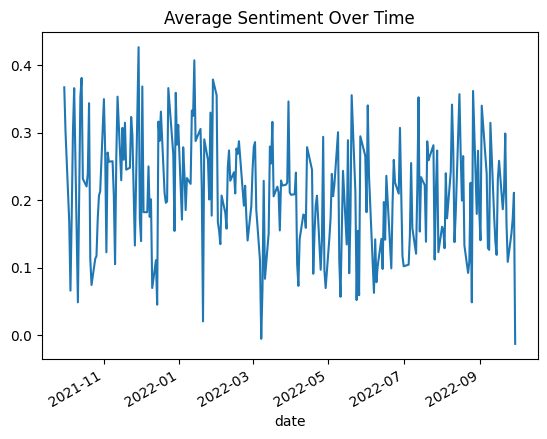

In [19]:
# Sentiment over time
df_merged.groupby('date')['avg_sentiment'].mean().plot(title="Average Sentiment Over Time")
plt.show()

### Closing Price Over Time

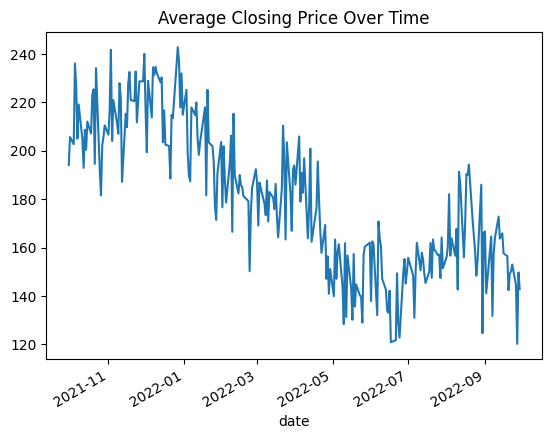

In [20]:
# Closing price over time
df_merged.groupby('date')['Close'].mean().plot(title="Average Closing Price Over Time")
plt.show()

### Correlation Heatmap

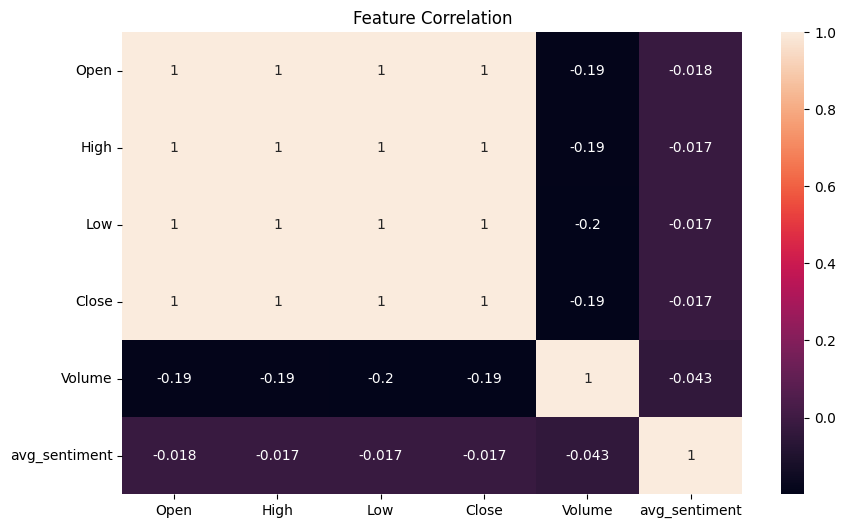

In [21]:
# Correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df_merged[['Open', 'High', 'Low', 'Close', 'Volume', 'avg_sentiment']].corr(), annot=True)
plt.title("Feature Correlation")
plt.show()

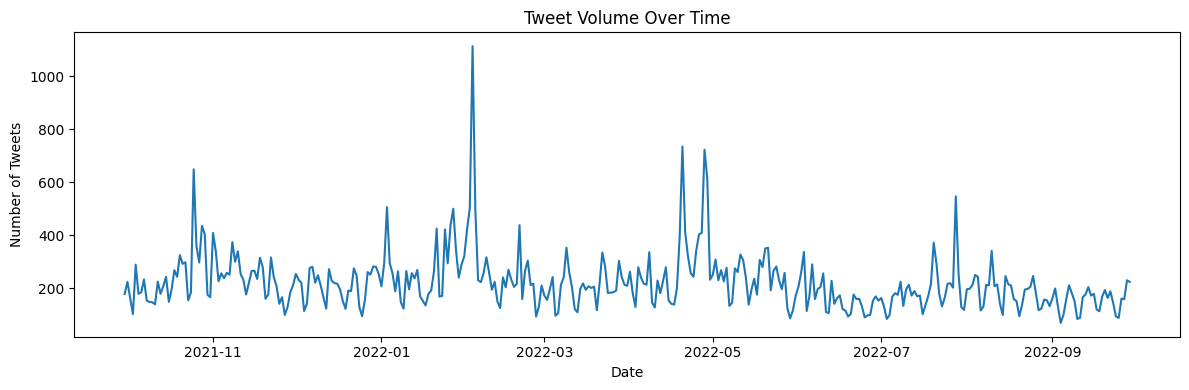

In [22]:
tweet_volume = df_tweets.groupby(df_tweets['Date'].dt.date).size()

plt.figure(figsize=(12, 4))
tweet_volume.plot()
plt.title("Tweet Volume Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Tweets")
plt.tight_layout()
plt.show()


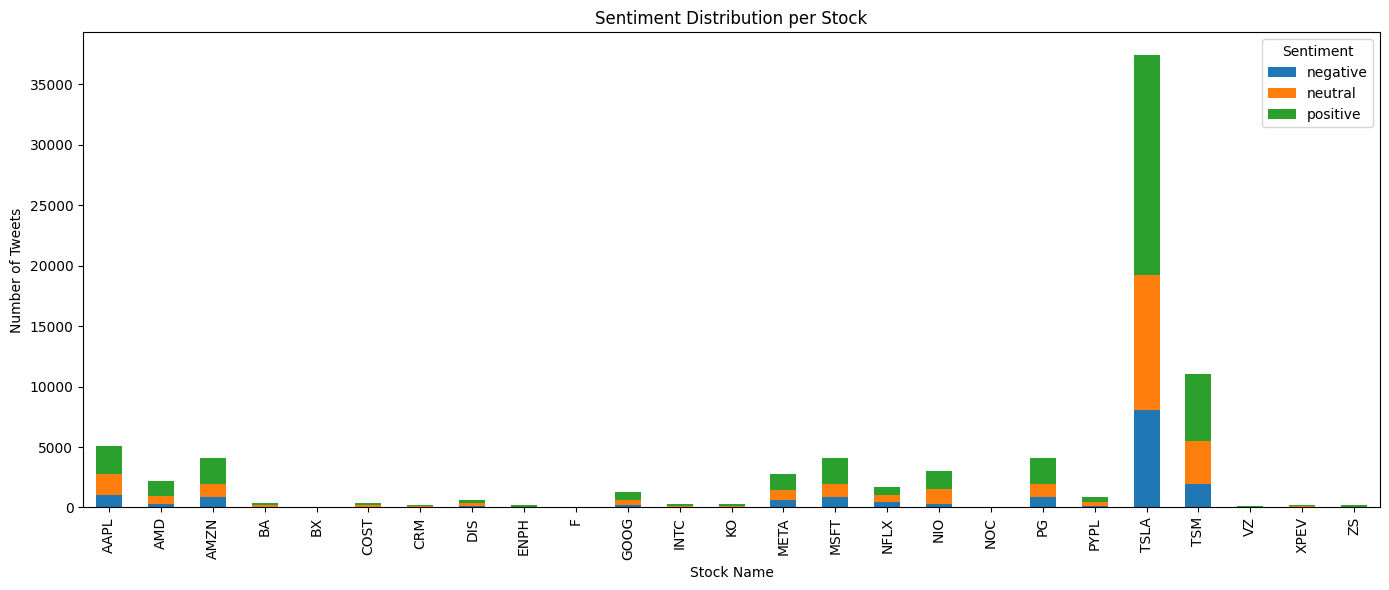

In [23]:
sentiment_by_stock = df_tweets.groupby(['Stock Name', 'sentiment']).size().unstack().fillna(0)

sentiment_by_stock.plot(kind='bar', stacked=True, figsize=(14, 6))
plt.title("Sentiment Distribution per Stock")
plt.xlabel("Stock Name")
plt.ylabel("Number of Tweets")
plt.legend(title="Sentiment")
plt.tight_layout()
plt.show()


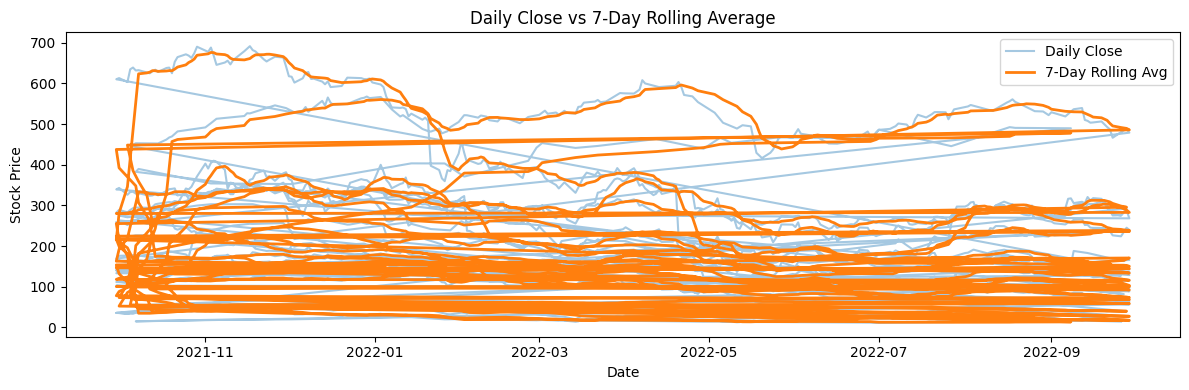

In [24]:
df_merged['rolling_close'] = df_merged['Close'].rolling(window=7).mean()

plt.figure(figsize=(12, 4))
plt.plot(df_merged['date'], df_merged['Close'], label="Daily Close", alpha=0.4)
plt.plot(df_merged['date'], df_merged['rolling_close'], label="7-Day Rolling Avg", linewidth=2)
plt.title("Daily Close vs 7-Day Rolling Average")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend()
plt.tight_layout()
plt.show()


# Feature Selection and Normalization

In [25]:
features = ['Open', 'High', 'Low', 'Close', 'Volume', 'avg_sentiment']
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_merged[features])

sequence_length = 10
X, y = [], []
target_index = features.index('Close')

for i in range(sequence_length, len(scaled_data)):
    X.append(scaled_data[i-sequence_length:i])
    y.append(scaled_data[i, target_index])

X, y = np.array(X), np.array(y)

# Split data
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


# Model Implementation

#  LSTM Implementation

In [26]:
model_lstm = Sequential()
model_lstm.add(LSTM(64, return_sequences=True, input_shape=(X.shape[1], X.shape[2])))
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(64))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(1))

model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


105/105 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - loss: 0.0152 - val_loss: 0.0033
Epoch 2/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0028 - val_loss: 0.0029
Epoch 3/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0028 - val_loss: 0.0024
Epoch 4/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 5/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0019 - val_loss: 0.0021
Epoch 6/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0019 - val_loss: 0.0020
Epoch 7/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0017 - val_loss: 0.0018
Epoch 8/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 9/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0017 - val_loss: 0.0015
Epoch 10/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 11/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0018 - val_loss: 0.0014
Epoch 12/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/ste

# GRU Implementation

In [27]:
model_gru = Sequential()
model_gru.add(GRU(64, return_sequences=True, input_shape=(X.shape[1], X.shape[2])))
model_gru.add(Dropout(0.2))
model_gru.add(GRU(64))
model_gru.add(Dropout(0.2))
model_gru.add(Dense(1))

model_gru.compile(optimizer='adam', loss='mse')
model_gru.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.0167 - val_loss: 0.0018
Epoch 2/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0025 - val_loss: 0.0016
Epoch 3/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0019 - val_loss: 0.0014
Epoch 4/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 5/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0016 - val_loss: 0.0013
Epoch 6/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0017 - val_loss: 0.0013
Epoch 7/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 8/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0016 - val_loss: 0.0012
Epoch 9/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 10/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0013 - val_loss: 0.0015
Epoch 11/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 12/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 

# CNN-LSTM Implementation

---



In [28]:
model_cnn_lstm = Sequential()
model_cnn_lstm.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X.shape[1], X.shape[2])))
model_cnn_lstm.add(MaxPooling1D(pool_size=2))
model_cnn_lstm.add(LSTM(64))
model_cnn_lstm.add(Dropout(0.2))
model_cnn_lstm.add(Dense(1))

model_cnn_lstm.compile(optimizer='adam', loss='mse')
model_cnn_lstm.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0176 - val_loss: 0.0040
Epoch 2/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0025 - val_loss: 0.0036
Epoch 3/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0024 - val_loss: 0.0030
Epoch 4/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0022 - val_loss: 0.0034
Epoch 5/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0020 - val_loss: 0.0028
Epoch 6/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0021 - val_loss: 0.0031
Epoch 7/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0021 - val_loss: 0.0024
Epoch 8/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0025 - val_loss: 0.0026
Epoch 9/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0020 - val_loss: 0.0025
Epoch 10/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0014 - val_loss: 0.0022
Epoch 11/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0016 - val_loss: 0.0023
Epoch 12/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0

#Bidirectional LSTM Implementation




In [29]:
from tensorflow.keras.layers import Bidirectional

model_bilstm = Sequential()
model_bilstm.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=(X.shape[1], X.shape[2])))
model_bilstm.add(Dropout(0.2))
model_bilstm.add(Bidirectional(LSTM(64)))
model_bilstm.add(Dropout(0.2))
model_bilstm.add(Dense(1))

model_bilstm.compile(optimizer='adam', loss='mse')

model_bilstm.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


105/105 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - loss: 0.0177 - val_loss: 0.0029
Epoch 2/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0022 - val_loss: 0.0023
Epoch 3/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 4/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 0.0015 - val_loss: 0.0018
Epoch 5/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 6/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0017 - val_loss: 0.0015
Epoch 7/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 0.0014 - val_loss: 0.0016
Epoch 8/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 0.0011 - val_loss: 0.0022
Epoch 9/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.0017 - val_loss: 0.0014
Epoch 10/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 11/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0016 - val_loss: 0.0013
Epoch 12/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/st

# Model Evaluation

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
LSTM Evaluation Metrics:
RMSE: 0.0348
MAE: 0.0176
Directional Accuracy: 51.4388


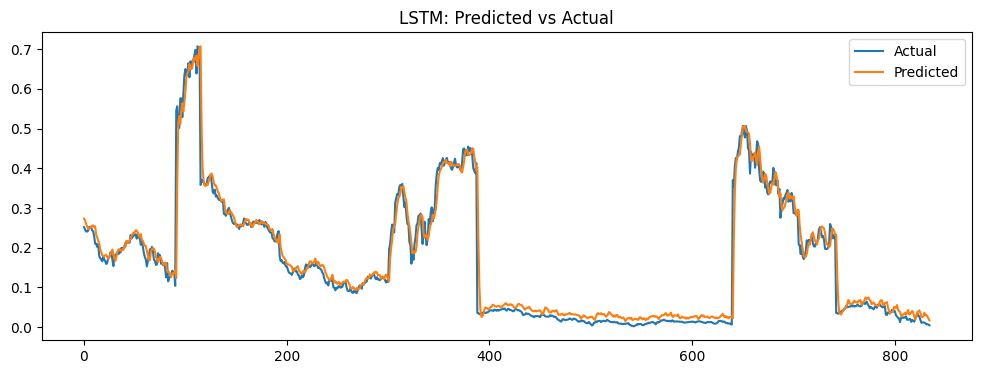

In [32]:
y_pred_lstm = model_lstm.predict(X_test)

rmse_lstm = np.sqrt(mean_squared_error(y_test, y_pred_lstm))
mae_lstm = mean_absolute_error(y_test, y_pred_lstm)

directional_acc_lstm = calculate_directional_accuracy(y_test, y_pred_lstm)

print("LSTM Evaluation Metrics:")
print(f"RMSE: {rmse_lstm:.4f}")
print(f"MAE: {mae_lstm:.4f}")
print(f"Directional Accuracy: {directional_acc_lstm:.4f}")

plt.figure(figsize=(12, 4))
plt.plot(y_test, label="Actual")
plt.plot(y_pred_lstm, label="Predicted")
plt.title("LSTM: Predicted vs Actual")
plt.legend()
plt.show()


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
GRU Evaluation Metrics:
RMSE: 0.0321
MAE: 0.0127
Directional Accuracy: 49.5204


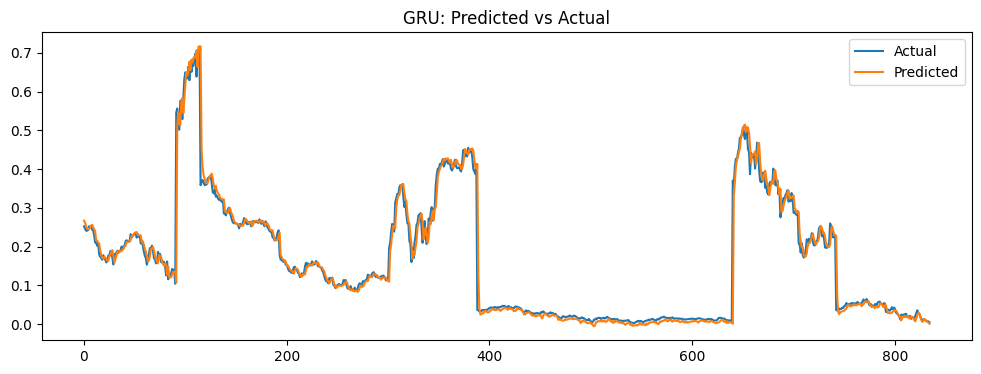

In [33]:
y_pred_gru = model_gru.predict(X_test)

rmse_gru = np.sqrt(mean_squared_error(y_test, y_pred_gru))
mae_gru = mean_absolute_error(y_test, y_pred_gru)

directional_acc_gru = calculate_directional_accuracy(y_test, y_pred_gru)

print("GRU Evaluation Metrics:")
print(f"RMSE: {rmse_gru:.4f}")
print(f"MAE: {mae_gru:.4f}")
print(f"Directional Accuracy: {directional_acc_gru:.4f}")

plt.figure(figsize=(12, 4))
plt.plot(y_test, label="Actual")
plt.plot(y_pred_gru, label="Predicted")
plt.title("GRU: Predicted vs Actual")
plt.legend()
plt.show()


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
CNN-LSTM Evaluation Metrics:
RMSE: 0.0486
MAE: 0.0296
Directional Accuracy: 50.1199


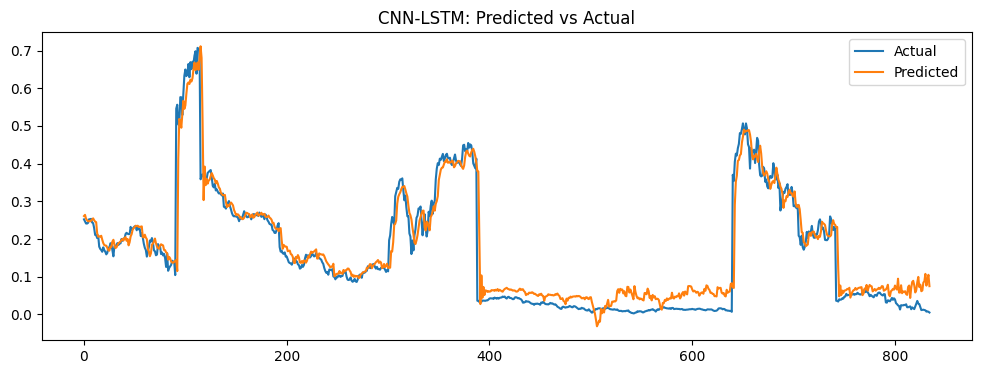

In [34]:
y_pred_cnn = model_cnn_lstm.predict(X_test)

rmse_cnn = np.sqrt(mean_squared_error(y_test, y_pred_cnn))
mae_cnn = mean_absolute_error(y_test, y_pred_cnn)

directional_acc_cnn = calculate_directional_accuracy(y_test, y_pred_cnn)

print("CNN-LSTM Evaluation Metrics:")
print(f"RMSE: {rmse_cnn:.4f}")
print(f"MAE: {mae_cnn:.4f}")
print(f"Directional Accuracy: {directional_acc_cnn:.4f}")

plt.figure(figsize=(12, 4))
plt.plot(y_test, label="Actual")
plt.plot(y_pred_cnn, label="Predicted")
plt.title("CNN-LSTM: Predicted vs Actual")
plt.legend()
plt.show()


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step
Bidirectional LSTM Evaluation Metrics:
RMSE: 0.0333
MAE: 0.0137
Directional Accuracy: 51.6787


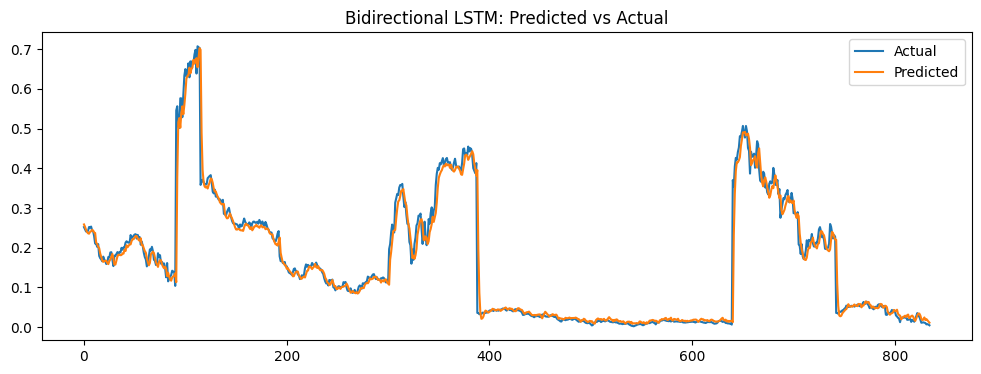

In [35]:
y_pred_bilstm = model_bilstm.predict(X_test)

rmse_bilstm = np.sqrt(mean_squared_error(y_test, y_pred_bilstm))
mae_bilstm = mean_absolute_error(y_test, y_pred_bilstm)

directional_acc_bilstm = calculate_directional_accuracy(y_test, y_pred_bilstm)

print("Bidirectional LSTM Evaluation Metrics:")
print(f"RMSE: {rmse_bilstm:.4f}")
print(f"MAE: {mae_bilstm:.4f}")
print(f"Directional Accuracy: {directional_acc_bilstm:.4f}")

plt.figure(figsize=(12, 4))
plt.plot(y_test, label="Actual")
plt.plot(y_pred_bilstm, label="Predicted")
plt.title("Bidirectional LSTM: Predicted vs Actual")
plt.legend()
plt.show()


# Model Comparison Summary

In [36]:
results_df = pd.DataFrame({
    'Model': ['LSTM', 'GRU', 'CNN-LSTM', 'Bidirectional LSTM'],
    'RMSE': [rmse_lstm, rmse_gru, rmse_cnn, rmse_bilstm],
    'MAE': [mae_lstm, mae_gru, mae_cnn, mae_bilstm],
    'Directional Accuracy': [directional_acc_lstm, directional_acc_gru, directional_acc_cnn, directional_acc_bilstm]
})

print("Model Performance Summary:")
print(results_df)


Model Performance Summary:
                Model      RMSE       MAE  Directional Accuracy
0                LSTM  0.034849  0.017586             51.438849
1                 GRU  0.032062  0.012699             49.520384
2            CNN-LSTM  0.048582  0.029560             50.119904
3  Bidirectional LSTM  0.033266  0.013663             51.678657
